In [2]:
import pandas as pd
import re
from rapidfuzz import process, fuzz
from collections import defaultdict

df = pd.read_csv('../data/steam-200k.csv', header=None)
df.columns = ['user-id', 'game-title', 'behavior', 'value', 'extra']
print(f"Initial shape: {df.shape}")
df.head()


Initial shape: (200000, 5)


,user-id,game-title,behavior,value,extra
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [3]:

print("Missing values per column:")
print(df.isnull().sum())


Missing values per column:
user-id       0
game-title    0
behavior      0
value         0
extra         0
dtype: int64


In [4]:

print("Unique values in 'extra':", df['extra'].unique())
df.drop(columns=['extra'], inplace=True)
print(f"Shape after dropping 'extra': {df.shape}")


Unique values in 'extra': [0]
Shape after dropping 'extra': (200000, 4)


In [5]:
exact_dupes = df.duplicated().sum()
print(f"Exact duplicate rows: {exact_dupes}")

df.drop_duplicates(inplace=True)
print(f"Shape after dropping exact duplicates: {df.shape}")


Exact duplicate rows: 707
Shape after dropping exact duplicates: (199293, 4)


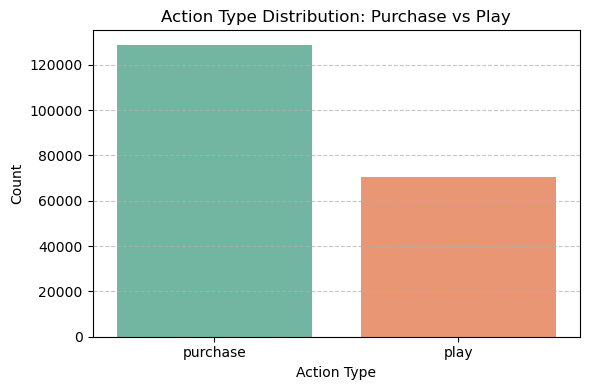

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
action_counts = df['behavior'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=action_counts.index, y=action_counts.values, palette='Set2')

plt.title('Action Type Distribution: Purchase vs Play')
plt.xlabel('Action Type')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:

plays = df[df['behavior'] == 'play']
purchases = df[df['behavior'] == 'purchase']

plays_cleaned = plays.groupby(['user-id', 'game-title'], as_index=False)['value'].sum()

final_df = pd.concat([purchases, plays_cleaned], ignore_index=True)

final_df.sort_values(by=['user-id', 'game-title'], inplace=True)
final_df.reset_index(drop=True, inplace=True)

print(f"Shape after aggregating play actions: {final_df.shape}")


Shape after aggregating play actions: (199281, 4)


In [7]:
def preprocess_title(title):
    title = title.lower()
    title = re.sub(r'[\W_]+', ' ', title)
    return title.strip()

final_df['clean-title'] = final_df['game-title'].apply(preprocess_title)

In [9]:
def is_probably_sequel(t1, t2):
    pattern = r'\b([ivx]+|\d+)\b'
    n1 = re.findall(pattern, t1.lower())
    n2 = re.findall(pattern, t2.lower())
    return bool(n1 and n2 and n1 != n2)

In [10]:
clean_titles = final_df['clean-title'].unique()
cluster_map = {}

for title in clean_titles:
    if title in cluster_map:
        continue
    matches = process.extract(title, clean_titles, scorer=fuzz.token_sort_ratio, limit=None)
    similar_titles = [m for m, score, _ in matches if score >= 90 and not is_probably_sequel(title, m)]
    canonical = max(similar_titles, key=len)
    for dup in similar_titles:
        cluster_map[dup] = canonical

In [ ]:
final_df['canonical-title'] = final_df['clean-title'].map(cluster_map)
final_df['game-title'] = final_df['canonical-title'].fillna(final_df['clean-title']).str.title()
final_df.drop(columns=['clean-title', 'canonical-title'], inplace=True)

print(" Fuzzy Deduplication Results:")
print("Before:", len(clean_titles))
print("After:", final_df['game-title'].nunique())

 Fuzzy Deduplication Results:
Before: 5151
After: 5026


In [12]:
titles = final_df['game-title'].unique()
fuzzy_dupe_count = 0

for i in range(len(titles)):
    for j in range(i + 1, len(titles)):
        if fuzz.token_sort_ratio(titles[i], titles[j]) >= 90:
            fuzzy_dupe_count += 1

print(f"Remaining fuzzy duplicate title pairs (≥90% similarity): {fuzzy_dupe_count}")


Remaining fuzzy duplicate title pairs (≥90% similarity): 175
